In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Paths
train_dir = r"C:\Users\anany\OneDrive\Desktop\Research Paper Publish\MRI\Training"
test_dir = r"C:\Users\anany\OneDrive\Desktop\Research Paper Publish\MRI\Testing"
img_size = 224
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    r'C:\Users\anany\OneDrive\Desktop\Research Paper Publish\MRI\Testing',  # <-- replace with your actual test path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)



class_names = list(train_generator.class_indices.keys())


Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


In [11]:
# Load the ResNet50 base model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)



Epoch 1/10
179/179 [==============================] - 560s 3s/step - loss: 1.2646 - accuracy: 0.4142 - val_loss: 1.2024 - val_accuracy: 0.4767
Epoch 2/10
179/179 [==============================] - 1579s 9s/step - loss: 1.1533 - accuracy: 0.5172 - val_loss: 1.1605 - val_accuracy: 0.5660
Epoch 3/10
179/179 [==============================] - 525s 3s/step - loss: 1.1036 - accuracy: 0.5476 - val_loss: 1.1493 - val_accuracy: 0.5027
Epoch 4/10
179/179 [==============================] - 550s 3s/step - loss: 1.0723 - accuracy: 0.5637 - val_loss: 1.1095 - val_accuracy: 0.5751
Epoch 5/10
179/179 [==============================] - 545s 3s/step - loss: 1.0479 - accuracy: 0.5692 - val_loss: 1.1031 - val_accuracy: 0.5698
Epoch 6/10
179/179 [==============================] - 1638s 9s/step - loss: 1.0252 - accuracy: 0.5804 - val_loss: 1.0667 - val_accuracy: 0.5896
Epoch 7/10
179/179 [==============================] - 822s 5s/step - loss: 1.0074 - accuracy: 0.5898 - val_loss: 1.0817 - val_accuracy: 0.56

In [14]:
# Unfreeze and fine-tune if needed
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune further
model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator
)


Epoch 1/5
179/179 [==============================] - 3806s 21s/step - loss: 0.1865 - accuracy: 0.9384 - val_loss: 6.6042 - val_accuracy: 0.3440
Epoch 2/5
179/179 [==============================] - 77081s 433s/step - loss: 0.1288 - accuracy: 0.9522 - val_loss: 3.1731 - val_accuracy: 0.4287
Epoch 3/5
179/179 [==============================] - 3689s 21s/step - loss: 0.0988 - accuracy: 0.9664 - val_loss: 2.1352 - val_accuracy: 0.5233
Epoch 4/5
179/179 [==============================] - 4081s 23s/step - loss: 0.0842 - accuracy: 0.9701 - val_loss: 1.3679 - val_accuracy: 0.6476
Epoch 5/5
179/179 [==============================] - 6408s 36s/step - loss: 0.0635 - accuracy: 0.9778 - val_loss: 0.2115 - val_accuracy: 0.9314


41/41 [==============================] - 120s 3s/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.88      0.92       300
  meningioma       0.94      0.88      0.91       306
     notumor       0.87      1.00      0.93       405
   pituitary       0.98      0.95      0.96       300

    accuracy                           0.93      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



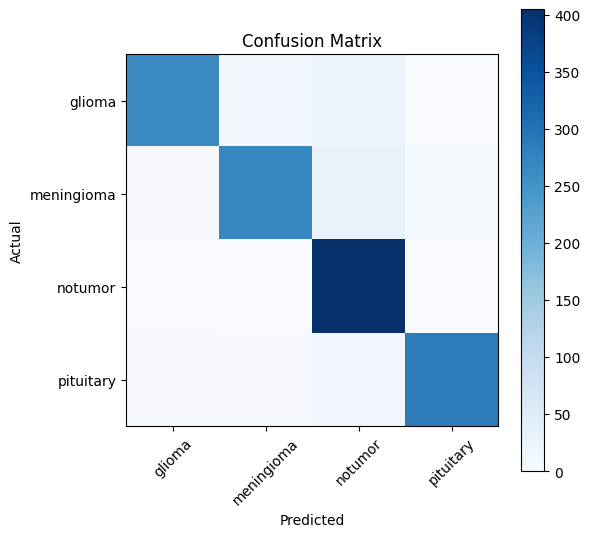

In [15]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

def predict_single_image(image_path):
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_label = idx_to_class[predicted_index]
    confidence = np.max(prediction) * 100

    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.title(f"{predicted_label} ({confidence:.2f}%)")
    plt.show()

    print(f"\nPredicted: {predicted_label} ({confidence:.2f}%)")


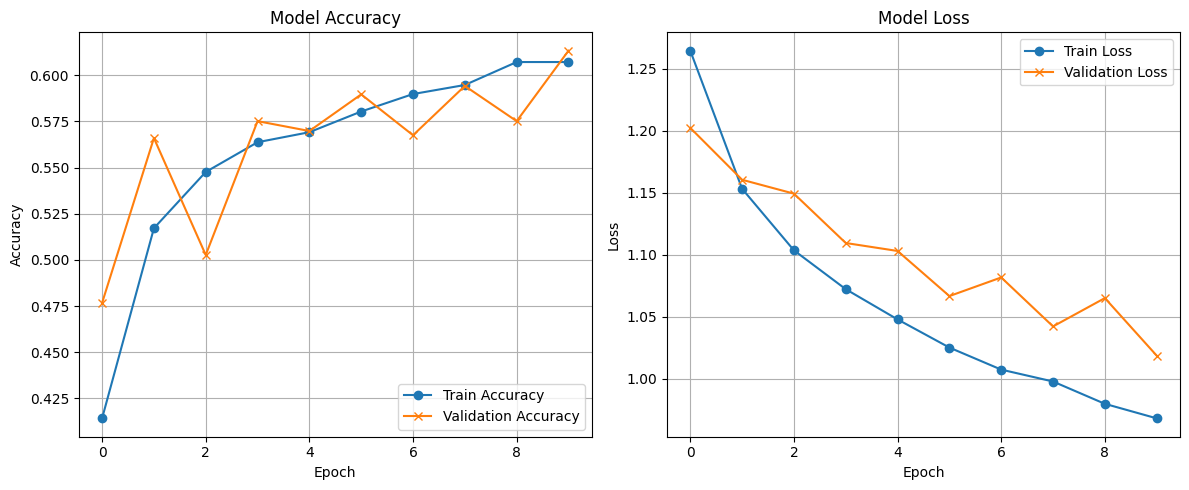

In [17]:
import matplotlib.pyplot as plt

def plot_training_graphs(history):
    # Accuracy graph
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss graph
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_graphs(history)


1/1 [==============================] - 3s 3s/step


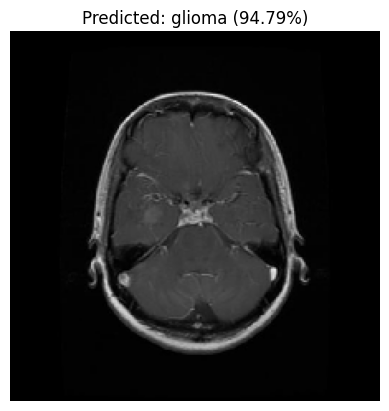


🧠 Predicted Tumor Type: glioma
📊 Confidence: 94.79%


In [20]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Mapping predicted index back to class name
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

def predict_single_image(image_path, model, img_size=224):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Make batch size = 1

    # Predict using the model
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_label = idx_to_class[predicted_index]
    confidence = np.max(predictions) * 100

    # Show the image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)")
    plt.show()

    print(f"\n🧠 Predicted Tumor Type: {predicted_label}")
    print(f"📊 Confidence: {confidence:.2f}%")

# Example usage:
# Put your own path below to test
image_path = r"C:\Users\anany\OneDrive\Desktop\Research Paper Publish\MRI\Testing\glioma\Te-gl_0013.jpg"
predict_single_image(image_path, model)


1/1 [==============================] - 0s 248ms/step


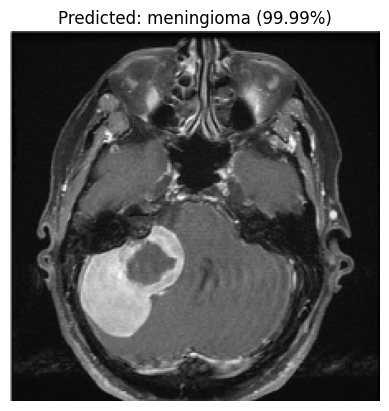


🧠 Predicted Tumor Type: meningioma
📊 Confidence: 99.99%


In [21]:
image_path = r"C:\Users\anany\OneDrive\Desktop\Research Paper Publish\MRI\Testing\meningioma\Te-me_0013.jpg"
predict_single_image(image_path, model)


1/1 [==============================] - 0s 263ms/step


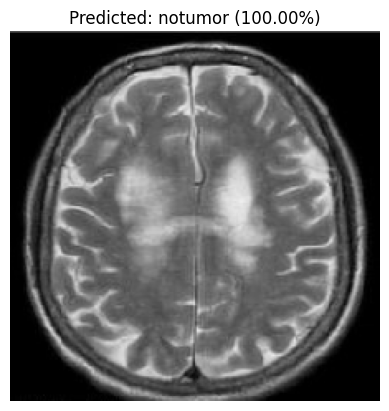


🧠 Predicted Tumor Type: notumor
📊 Confidence: 100.00%


In [22]:
image_path = r"C:\Users\anany\OneDrive\Desktop\Research Paper Publish\MRI\Testing\notumor\Te-no_0014.jpg"
predict_single_image(image_path, model)


1/1 [==============================] - 0s 239ms/step


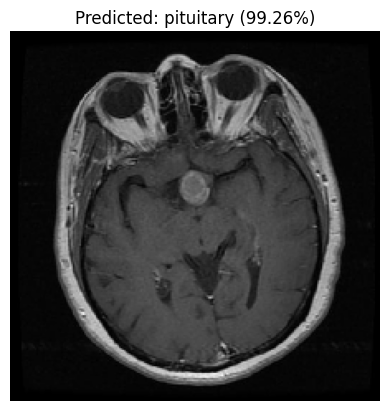


🧠 Predicted Tumor Type: pituitary
📊 Confidence: 99.26%


In [23]:
image_path = r"C:\Users\anany\OneDrive\Desktop\Research Paper Publish\MRI\Testing\pituitary\Te-pi_0015.jpg"
predict_single_image(image_path, model)
